# Week 3 Assignment

To join a Kaggle competition in which there is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2

layers = keras.layers
models = keras.models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

Let's do some cursory EDA; including looking at the train and val dataset first. We will look at the count, the px size, then we will prepare the dataset and look at abit more of the EDA.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 3/train_labels.csv')
df.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
class_counts = df['label'].value_counts()
print(class_counts)
print(f'Percentage of positive classifications is: {(class_counts[1]*100/len(df)):.2f}%')

label
0    130908
1     89117
Name: count, dtype: int64
Percentage of positive classifications is: 40.50%


This is actually quite a balanced dataset. In medical datasets, a common problem is that the positive classes usually end up quite imbalanced (low) and techniques have to be employed to either weigh/ boost the positive class.

In [ ]:
tfrecord_file = "/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 3/histopathologic_dataset.tfrecord"
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)

Let's look at just one image!

In [ ]:
image_path = "/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 3/0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif"

image = Image.open(image_path)

width, height = image.size
mode = image.mode

print(f"Image Size: {width} x {height}")
print(f"Color Mode: {mode}")

Image Size: 96 x 96
Color Mode: RGB


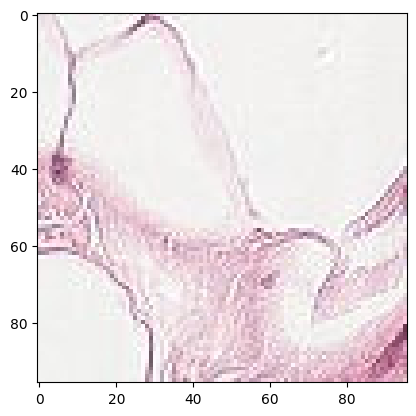

In [ ]:
plt.imshow(image)
plt.show()

# Preparation of Dataset

So this portion is really problematic because of the extremely large training data available. I kept hitting I/O limit on google colaboratory. As such, after much searching, the best way is to use [tfrecords](https://www.tensorflow.org/tutorials/load_data/tfrecord#writing_a_tfrecord_file) which was what was being done. You can read about it in the link. When the file is being written in, the image, and the label from the train.csv were being identified.

In [ ]:
def parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)

    image_bytes = parsed_features['image'].numpy()

    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_UNCHANGED)

    if image is None:
        image = Image.open(io.BytesIO(image_bytes))
        image = np.array(image)

    image = cv2.resize(image, (224, 224))

    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = image / 255.0
    label = tf.convert_to_tensor(parsed_features['label'], dtype=tf.int64)

    return image, label


for image, label in raw_dataset.map(lambda x: tf.py_function(parse_function, [x], [tf.float32, tf.int64])).take(1):
    image = np.array(image)
    print(f"Final Image Shape: {image.shape}, Label: {label.numpy()}")

Final Image Shape: (224, 224, 3), Label: 0


If you look at the extracted zip folder, the images are all in one folder with only the train.csv providing information about the classification. We will split the df into train and val_df, thereafter, we will preprocess the image and prepare it for the convnext model.

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
SEED = 1108

tf.random.set_seed(SEED)

parsed_dataset = raw_dataset.map(lambda x: tf.py_function(parse_function, [x], [tf.float32, tf.int64]))
parsed_dataset = parsed_dataset.map(lambda img, lbl: (tf.ensure_shape(img, [224, 224, 3]), tf.ensure_shape(lbl, [])))
parsed_dataset = parsed_dataset.shuffle(1000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
checking_count = sum(1 for _ in parsed_dataset.unbatch())
print(checking_count)

220025


In [ ]:
dataset_size = sum(1 for _ in parsed_dataset)
print(dataset_size)

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = parsed_dataset.take(train_size)
val_dataset = parsed_dataset.skip(train_size)

3438


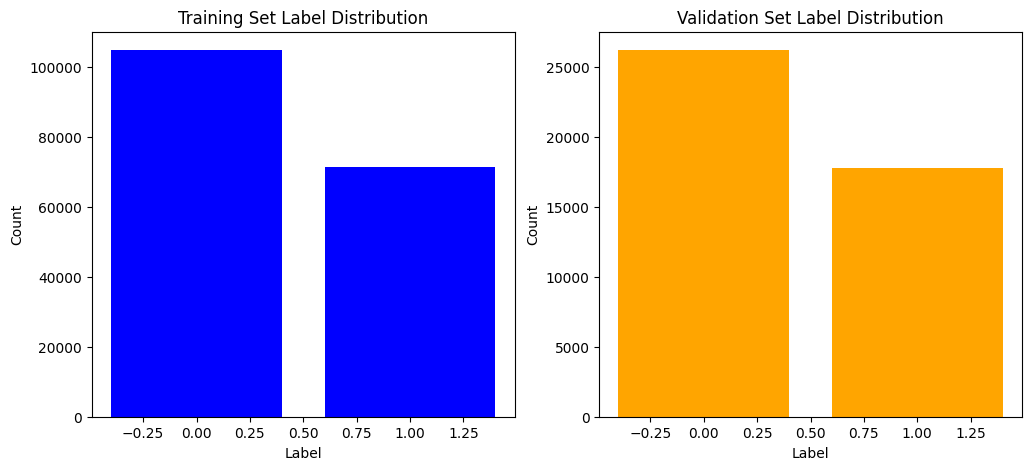

In [ ]:
train_labels = [label.numpy() for _, label in train_dataset.unbatch()]
val_labels = [label.numpy() for _, label in val_dataset.unbatch()]

train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(range(len(train_counts)), train_counts, color='blue')
ax[0].set_title("Training Set Label Distribution")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")

ax[1].bar(range(len(val_counts)), val_counts, color='orange')
ax[1].set_title("Validation Set Label Distribution")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")

plt.show()

# Training the model

Now I will train the model, and tune the hyperparameters. I will start with a model resnet50v2. Initially, I tried to use convnext but it was taking too long to train, possibly due to greater computations needs and the runtime kept getting disconnected before the training was completed.

In the initial model, I used resnet50v2 with weights from imagenet and set the base_model.trainable to False. I chose 128 neurons for the fully connected layer. The val accuracy was actually pretty decent at 0.89. Subsequently, I reduced the neurons for the fully connected layer to 64 and was still able to achieve a similar val accuracy. This suggests that having 128 neurons was redundant given the complexity of our model.


Lastly, in view of the large training samples that we were given, I had to make the base_model trainable True (at least once to test it). It gave a much better result, val_accuracy of 0.96, which was what was utilized eventually.

In [4]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)


Epoch 1/10
   2750/Unknown 447s 156ms/step - accuracy: 0.8152 - loss: 0.4079

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2750/2750 ━━━━━━━━━━━━━━━━━━━━ 921s 328ms/step - accuracy: 0.8152 - loss: 0.4079 - val_accuracy: 0.8691 - val_loss: 0.3038
Epoch 2/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 901s 327ms/step - accuracy: 0.8676 - loss: 0.3111 - val_accuracy: 0.8792 - val_loss: 0.2844
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 899s 326ms/step - accuracy: 0.8776 - loss: 0.2924 - val_accuracy: 0.8828 - val_loss: 0.2755
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 897s 325ms/step - accuracy: 0.8836 - loss: 0.2801 - val_accuracy: 0.8871 - val_loss: 0.2675
Epoch 5/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 894s 324ms/step - accuracy: 0.8882 - loss: 0.2716 - val_accuracy: 0.8905 - val_loss: 0.2612
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 901s 327ms/step - accuracy: 0.8915 - loss: 0.2628 - val_accuracy: 0.8931 - val_loss: 0.2574
Epoch 7/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 896s 325ms/step - accuracy: 0.8951 - loss: 0.2574 - val_accuracy: 0.8945 - val_loss: 0.2528
Epoch 8/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 896s 325ms/step - accuracy: 0.8

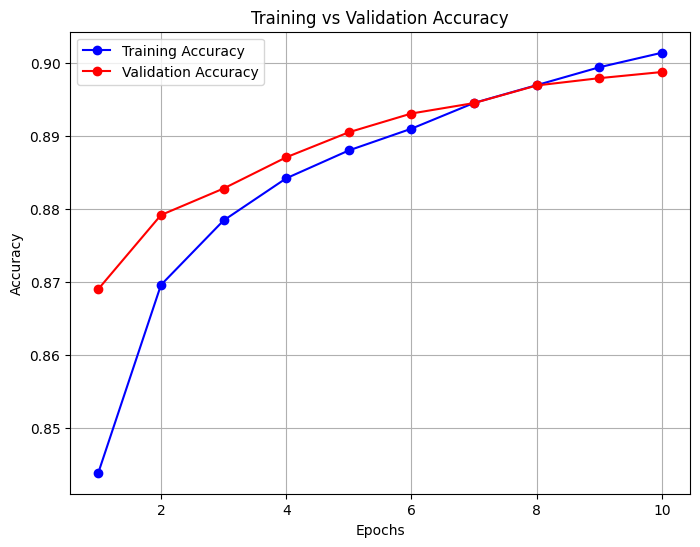

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("model_1.keras")

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,696,001 (90.39 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 910s 326ms/step - accuracy: 0.8095 - loss: 0.4216 - val_accuracy: 0.8651 - val_loss: 0.3121
Epoch 2/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 895s 324ms/step - accuracy: 0.8636 - loss: 0.3243 - val_accuracy: 0.8735 - val_loss: 0.2946
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 896s 325ms/step - accuracy: 0.8719 - loss: 0.3050 - val_accuracy: 0.8804 - val_loss: 0.2819
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 896s 325ms/step - accuracy: 0.8776 - loss: 0.2930 - val_accuracy: 0.8842 - val_loss: 0.2751
Epoch 5/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 898s 326ms/step - accuracy: 0.8812 - loss: 0.2847 - val_accuracy: 0.8861 - val_loss: 0.2698
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 894s 324ms/step - accuracy: 0.8847 - loss: 0.2786 - val_accuracy: 0.8881 - val_loss: 0.2656
Epoch 7/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 902s 327ms/step - accuracy: 0.8873 - loss: 0.2729 - val_accuracy: 0.8894 - val_loss: 0.2629
Epoch 8/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 898s 326ms/step - ac

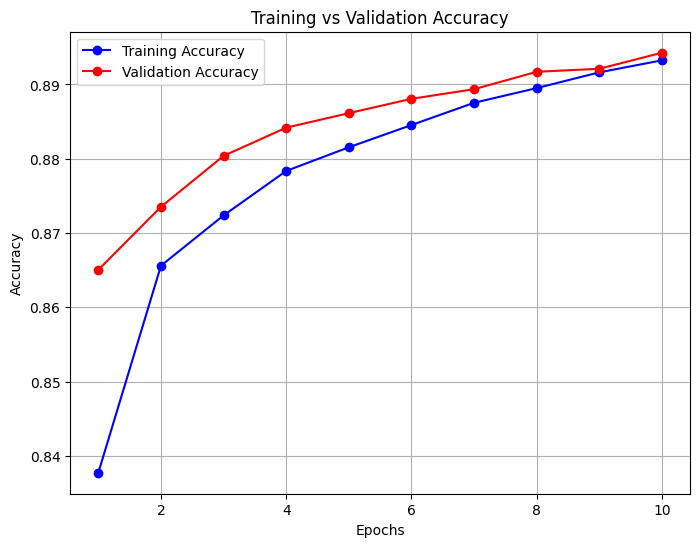

In [ ]:
train_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs = range(1, len(train_acc2) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc2, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc2, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("model_2.keras")

In [ ]:
base_model2 = tf.keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model2.trainable = True

model3 = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,696,001 (90.39 MB)

 Trainable params: 23,650,561 (90.22 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1065s 367ms/step - accuracy: 0.9012 - loss: 0.2467 - val_accuracy: 0.9398 - val_loss: 0.1671
Epoch 2/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1004s 364ms/step - accuracy: 0.9560 - loss: 0.1255 - val_accuracy: 0.9428 - val_loss: 0.1661
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1010s 366ms/step - accuracy: 0.9704 - loss: 0.0865 - val_accuracy: 0.9013 - val_loss: 0.3148
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1008s 366ms/step - accuracy: 0.9794 - loss: 0.0611 - val_accuracy: 0.9530 - val_loss: 0.1586
Epoch 5/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1004s 364ms/step - accuracy: 0.9838 - loss: 0.0451 - val_accuracy: 0.9549 - val_loss: 0.1615
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1004s 364ms/step - accuracy: 0.9870 - loss: 0.0368 - val_accuracy: 0.9554 - val_loss: 0.1469
Epoch 7/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1006s 365ms/step - accuracy: 0.9890 - loss: 0.0308 - val_accuracy: 0.9424 - val_loss: 0.2388
Epoch 8/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1007s 365ms/s

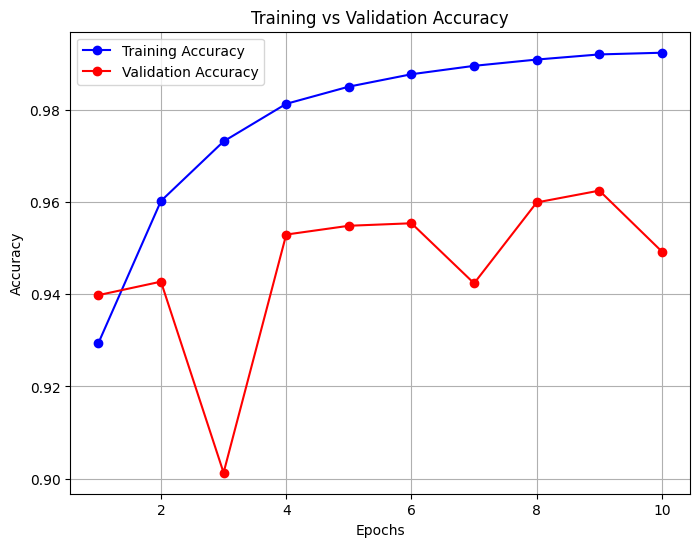

In [ ]:
train_acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

epochs = range(1, len(train_acc3) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc3, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc3, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("model_3.keras")

# Test output

In [5]:
def parse_function_test(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }

    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_bytes = parsed_features['image'].numpy()
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_UNCHANGED)
    if image is None:
        image = Image.open(io.BytesIO(image_bytes))
        image = np.array(image)

    image = cv2.resize(image, (224, 224))
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = image / 255.0

    filename = parsed_features['filename'].numpy().decode('utf-8')

    return image, filename

In [7]:
tfrecord_file = '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 3/histopathologic_dataset_test.tfrecord'
raw_test_dataset = tf.data.TFRecordDataset(tfrecord_file)

test_dataset = raw_test_dataset.map(
    lambda x: tf.py_function(parse_function_test, [x], [tf.float32, tf.string])
).batch(32)

allFilenames = []
allPredictions = []

model = tf.keras.models.load_model('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 3/model_3.keras')

for batch_images, batch_filenames in test_dataset:
    predictions = model.predict(batch_images)
    allPredictions.extend(predictions.tolist())
    batch_filenames = [fname.numpy().decode('utf-8') for fname in batch_filenames]
    allFilenames.extend(batch_filenames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

In [10]:
df = pd.DataFrame({
    'id': allFilenames,
    'label': allPredictions
})

In [11]:
df.head(5)

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif,[0.7306638956069946]
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif,[0.3799240291118622]
2,19709bec800f372d0b1d085da6933dd3ef108846.tif,[0.5530744194984436]
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif,[0.11619500070810318]
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif,[0.040998172014951706]


In [15]:
df['id'] = df['id'].str.replace('.tif', '', regex=False)
df['label'] = df['label'].apply(lambda x: 1 if x[0] > 0.5 else 0)

df.head(5)

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [16]:
df.to_csv('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 3/test_predictions.csv', index=False)

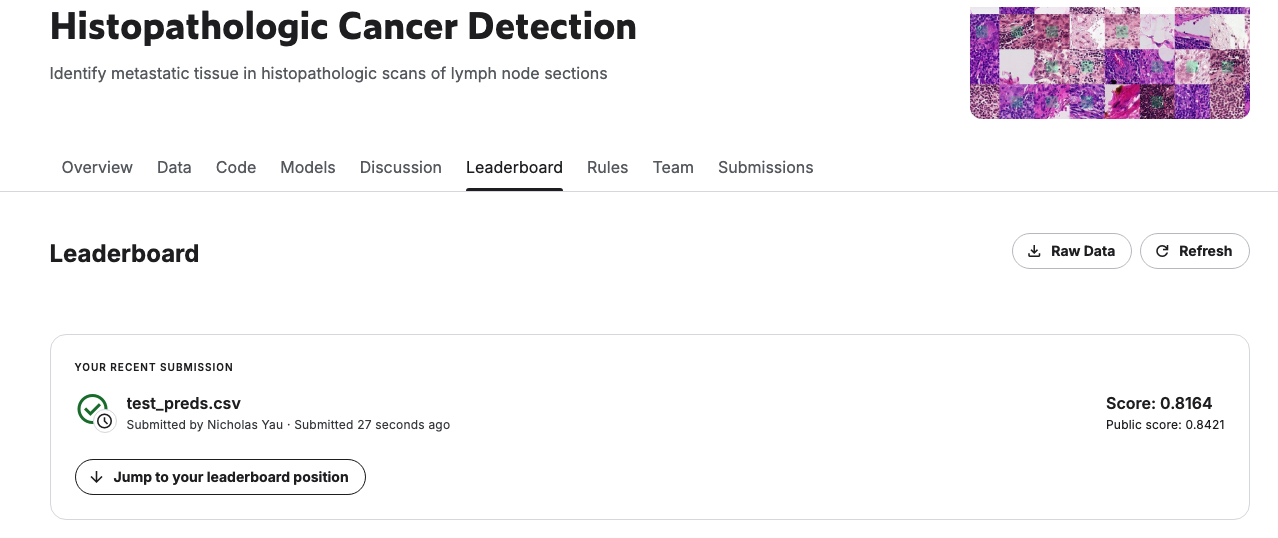